# MNIST Image Generation with LSTM
### Author: Rishikesh Kakde

### Library Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random

### Dataset Preparation

In [2]:
# Custom MNIST Dataset Class
class CustomMNIST(MNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pixel_data = self.data.unsqueeze(1).float().div(255)
        self.pixel_data, self.labels = self.pixel_data.to(device), self.targets.to(device)

    def __getitem__(self, idx):
        return self.pixel_data[idx], self.labels[idx]

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load datasets
train_dataset = CustomMNIST('data/MNIST', train=True, download=True)
test_dataset = CustomMNIST('data/MNIST', train=False, download=True)

# Split training data for validation
train_size = len(train_dataset) - 10000
train_data = train_dataset.pixel_data[:train_size]
train_labels = train_dataset.labels[:train_size]
val_data = train_dataset.pixel_data[train_size:]
val_labels = train_dataset.labels[train_size:]

# Image to patches
def split_into_patches(images):
    return F.unfold(images, kernel_size=7, stride=7).permute(0, 2, 1)

train_patches = split_into_patches(train_data)
test_patches = split_into_patches(test_dataset.pixel_data)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12854544.77it/s]


Extracting data/MNIST/CustomMNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/CustomMNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 337394.32it/s]


Extracting data/MNIST/CustomMNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/CustomMNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3180907.72it/s]


Extracting data/MNIST/CustomMNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/CustomMNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2848890.20it/s]


Extracting data/MNIST/CustomMNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/CustomMNIST/raw



### DataLoader Creation

In [3]:
def create_dataloader(patches, batch_size=100, shuffle=True):
    inputs = patches[:, :15, :]
    targets = patches[:, 1:, :]
    dataset = TensorDataset(inputs, targets)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = create_dataloader(train_patches)
test_loader = create_dataloader(test_patches, shuffle=False)

### Model Definition

In [4]:
class SequencePredictor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)
        self.activation = nn.Tanh()

    def forward(self, x, hidden=None):
        if hidden is None:
            hidden = self.initialize_hidden(x.size(0))
        output, hidden = self.rnn(x, hidden)
        output = self.activation(self.fc(output))
        return output, hidden

    def initialize_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

### Training and Validation

In [5]:
# Initialize model, optimizer, and loss function
model = SequencePredictor(input_size=49).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training and validation loops
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for inputs, targets in loader:
        optimizer.zero_grad()
        predictions, _ = model(inputs)
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate_model(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in loader:
            predictions, _ = model(inputs)
            loss = criterion(predictions, targets)
            total_loss += loss.item()
    return total_loss / len(loader)

# Training loop with early stopping
def train_model(model, epochs, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss = validate_model(model, test_loader, criterion)
        print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

train_model(model, epochs=200, patience=10)

Epoch 1: Train Loss = 0.0630, Val Loss = 0.0482
Epoch 2: Train Loss = 0.0449, Val Loss = 0.0423
Epoch 3: Train Loss = 0.0411, Val Loss = 0.0397
Epoch 4: Train Loss = 0.0391, Val Loss = 0.0384
Epoch 5: Train Loss = 0.0378, Val Loss = 0.0372
Epoch 6: Train Loss = 0.0369, Val Loss = 0.0362
Epoch 7: Train Loss = 0.0362, Val Loss = 0.0356
Epoch 8: Train Loss = 0.0356, Val Loss = 0.0351
Epoch 9: Train Loss = 0.0351, Val Loss = 0.0348
Epoch 10: Train Loss = 0.0347, Val Loss = 0.0344
Epoch 11: Train Loss = 0.0344, Val Loss = 0.0341
Epoch 12: Train Loss = 0.0341, Val Loss = 0.0339
Epoch 13: Train Loss = 0.0338, Val Loss = 0.0336
Epoch 14: Train Loss = 0.0335, Val Loss = 0.0333
Epoch 15: Train Loss = 0.0333, Val Loss = 0.0332
Epoch 16: Train Loss = 0.0331, Val Loss = 0.0330
Epoch 17: Train Loss = 0.0330, Val Loss = 0.0328
Epoch 18: Train Loss = 0.0328, Val Loss = 0.0327
Epoch 19: Train Loss = 0.0326, Val Loss = 0.0325
Epoch 20: Train Loss = 0.0325, Val Loss = 0.0324
Epoch 21: Train Loss = 0.0323

### Image Generation

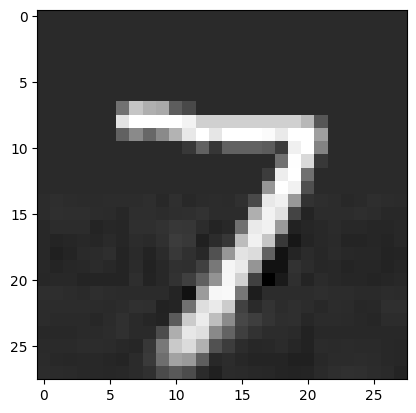

In [7]:
def generate_bottom_half(image):
    patches = F.unfold(image.unsqueeze(0), kernel_size=7, stride=7).permute(0, 2, 1)[:, :15, :]
    sequence = torch.zeros(16, 49).to(device)  # Ensure sequence is on the correct device
    sequence[:8] = patches.squeeze()[:8]

    hidden = model.initialize_hidden(1)
    output, hidden = model(patches, hidden)
    
    # Only assign the last 8 patches predicted by the model
    sequence[8:] = output.squeeze().detach()[-8:]

    # Reconstruct the image
    reconstructed = F.fold(sequence.unsqueeze(0).permute(0, 2, 1), output_size=(28, 28), kernel_size=7, stride=7)
    return reconstructed.squeeze().cpu().numpy()

# Generate example
test_image = test_dataset.pixel_data[0]
generated_image = generate_bottom_half(test_image)
plt.imshow(generated_image, cmap='gray')
plt.show()

### Generate and Compare Multiple Images

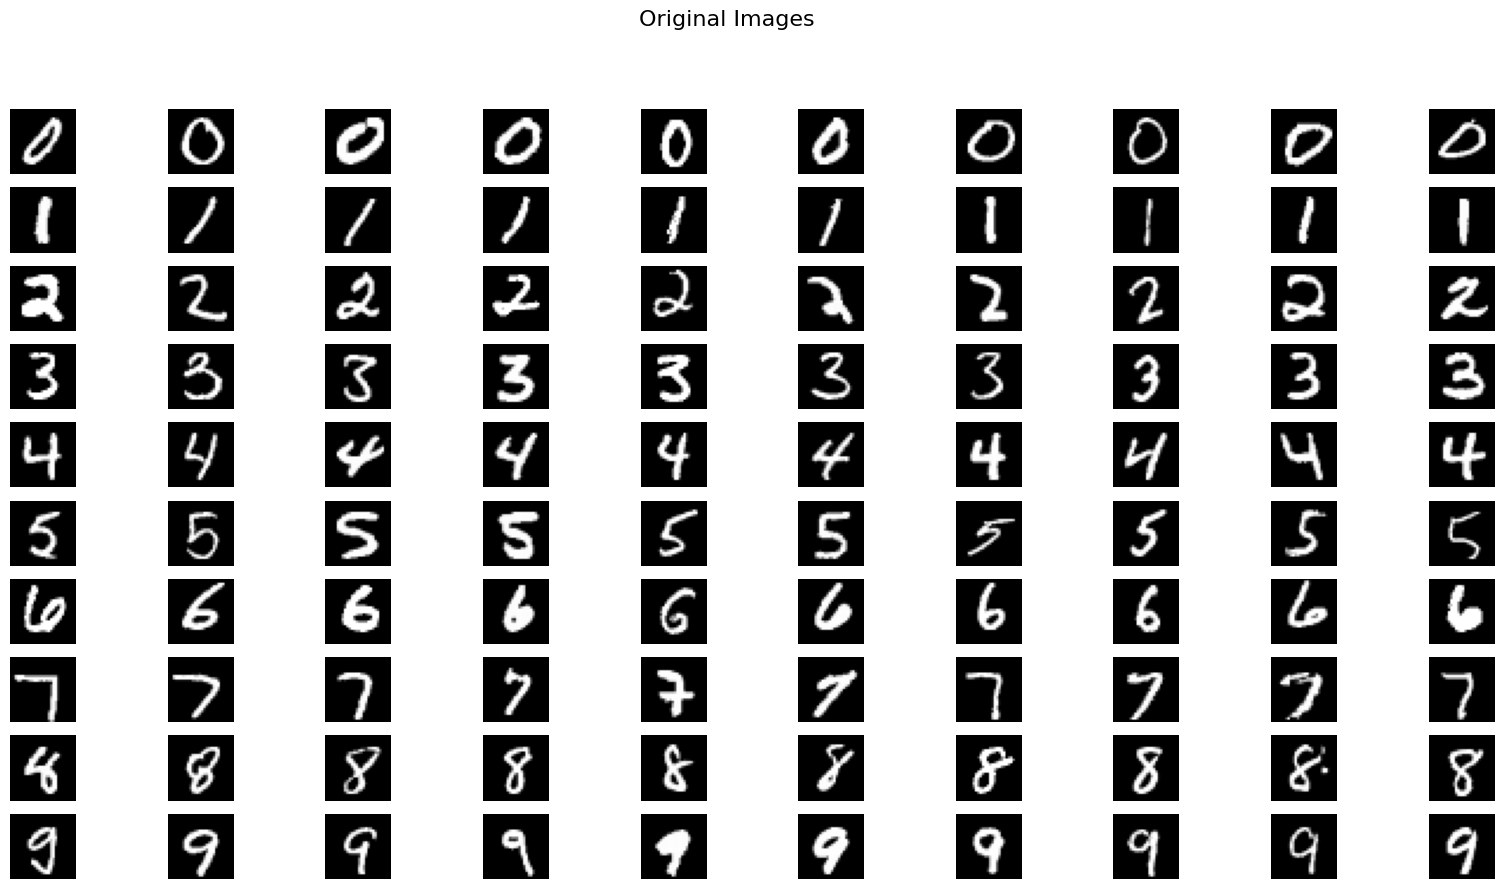

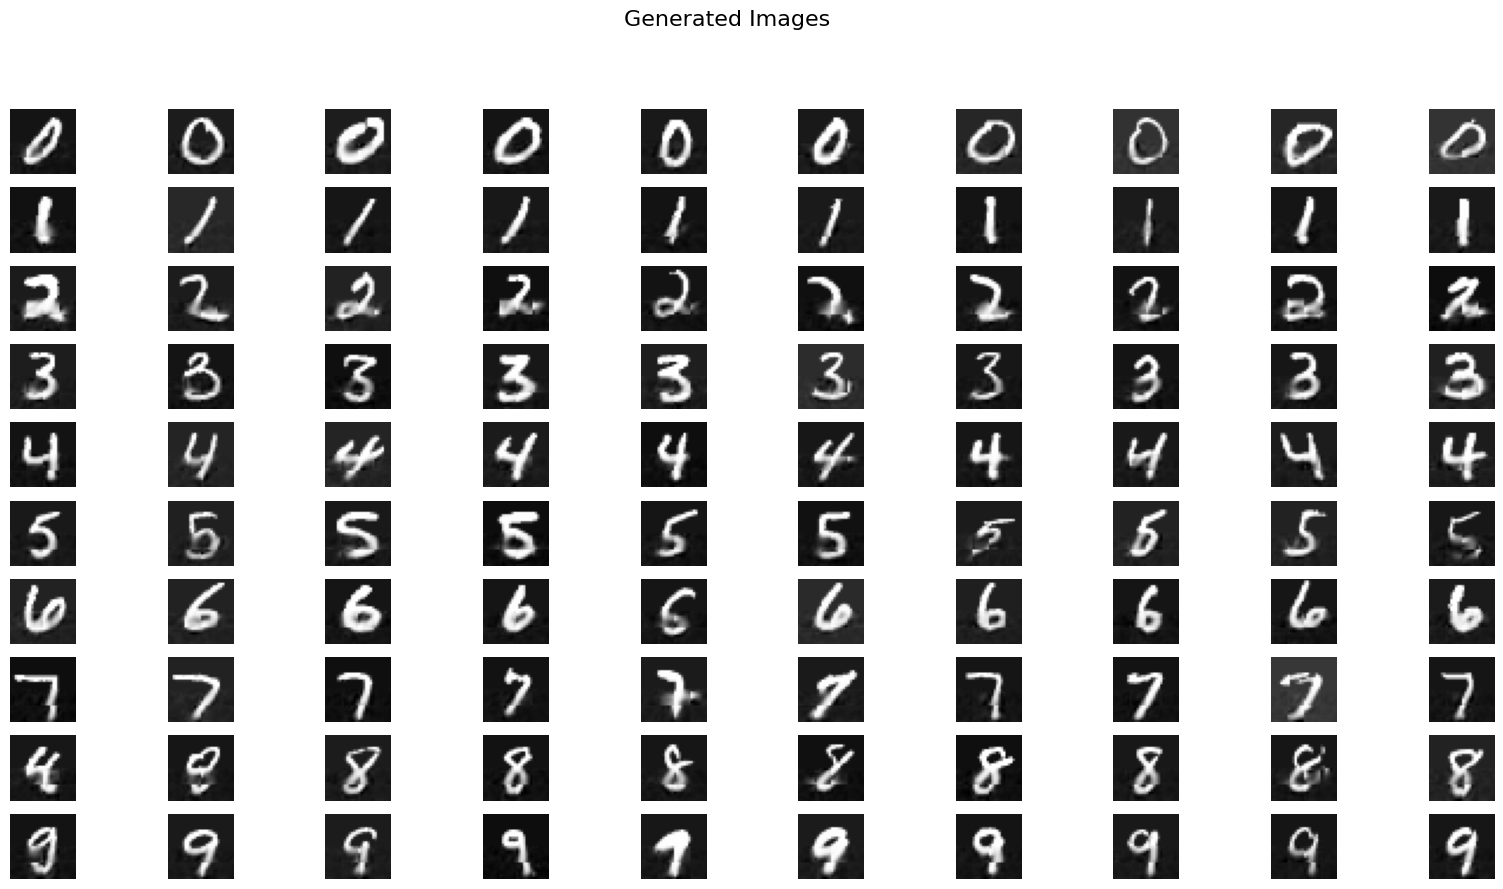

In [9]:
# Generate sequences for all digit classes
digit_images = {digit: [] for digit in range(10)}
num_images_per_class = 10

for digit in range(10):
    indices = [i for i, (_, label) in enumerate(test_dataset) if label == digit]
    selected = random.sample(indices, num_images_per_class)
    digit_images[digit] = [test_dataset[i][0] for i in selected]

# Generate corresponding images
generated_images = {digit: [generate_bottom_half(img) for img in imgs] for digit, imgs in digit_images.items()}

# Plot original images
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(10, 10)

for digit, imgs in digit_images.items():
    for i, img in enumerate(imgs):
        ax = plt.subplot(gs[digit, i])
        ax.imshow(img.cpu().numpy().reshape(28, 28), cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_ylabel(f'Digit {digit}', fontsize=10, rotation=0, labelpad=40)

plt.suptitle("Original Images", fontsize=16)
plt.show()

# Plot generated images
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(10, 10)

for digit, imgs in generated_images.items():
    for i, img in enumerate(imgs):
        ax = plt.subplot(gs[digit, i])
        ax.imshow(img.reshape(28, 28), cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_ylabel(f'Digit {digit}', fontsize=10, rotation=0, labelpad=40)

plt.suptitle("Generated Images", fontsize=16)
plt.show()